In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
from time import sleep
from pos_subtes_y_trenes_capital import medios_transporte
from utils_analisis import latLonToInt
#para calcular distancias usamos great_circle porque vincenty tarda mucho
from geopy.distance import great_circle

In [5]:
df = pd.read_csv("datosCabaYGBA.csv",low_memory = False)

In [6]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [7]:
df = df[~(df["place_with_parent_names"].str.contains("La Plata"))]

# Analizamos la evolucion del precio de una propiedad alrededor de la estacion de subte Las Heras, a traves del tiempo, tener en cuenta que se inauguró en diciembre de 2015

In [6]:

propsCapital = df[df["place_with_parent_names"].str.contains("Capital Federal")]


In [7]:
propsCapital = propsCapital.dropna(subset = ["lat-lon"])

In [8]:
propsCapital = propsCapital[propsCapital["place_name"] != "Capital Federal"] #No es un barrio de CABA

In [9]:
propsCapital = propsCapital[["property_type","created_on",\
                             "lat-lon","place_name","price_aprox_usd",\
                             "price_usd_per_m2","surface_total_in_m2"]]

In [10]:
propsRecoleta = propsCapital[propsCapital["place_name"] == "Recoleta"]

# Me quedo con propiedades con superficie total dentro de un determinado rango

In [11]:

estacionLH = (-34.588203, -58.398268)


In [12]:
propsRecoleta["DistEstacionLH"] = propsRecoleta.apply(lambda row: great_circle(latLonToInt(row["lat-lon"]),estacionLH),axis=1)

/home/tomas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [13]:
#Me quedo con las propiedades que estan en unradio de 600 metros de la stacion LH y con un tamaño dentro del promedio
cercanas = propsRecoleta[propsRecoleta["DistEstacionLH"] <= 0.8 ]
cercanas = cercanas[cercanas["price_aprox_usd"] > 0]
promSupTotal = cercanas["surface_total_in_m2"].mean()
cercanas = cercanas[(cercanas["surface_total_in_m2"] < promSupTotal + 20 ) & (cercanas["surface_total_in_m2"] > promSupTotal - 20 )]

In [14]:
cercanas["YearMonthCreation"] = cercanas.apply(lambda row:\
                                "-".join(row["created_on"].split("-")[:2]),axis=1)

In [15]:
#La propiedad con index 174462 tiene un precio por m2 muy extraño en comparacion a otras. Lo elimino

In [16]:
grouped = cercanas.loc[:,['YearMonthCreation','price_aprox_usd']].groupby('YearMonthCreation').\
    agg([np.mean])

In [17]:
grouped.index.rename("Año - mes",inplace= True)


# Estudio que pasa en tiempos cercanos a la inauguracion del subte

In [18]:
import matplotlib.dates as mdates

In [19]:
grouped = grouped.loc[(grouped.index < '2017-09') & (grouped.index > '2015-10')]

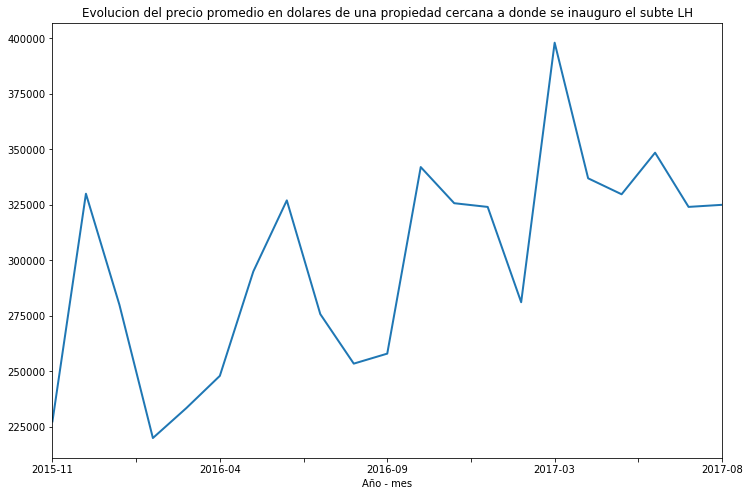

In [20]:

grouped.plot(linewidth=2,figsize=(12,8),legend=False,title="Evolucion del precio promedio en dolares de una propiedad cercana a donde se inauguro el subte LH")

In [21]:
plt.show()

### Conclusiones:
#### Se observa un alza en el precio de las propiedades cercanas a la estacion de subte a lo largo del tiempo a partir de que se instauró el subte en la zona 

# En los últimos 3 años, que relacion se ve sobre el precio de las distintas propiedades con la distancia a los principales medio de transporte? (Tren y Subte)

In [23]:
propsCapital = propsCapital[propsCapital["price_aprox_usd"] > 0]

In [29]:
propsCapital["distMinTransporte"] = propsCapital.apply(lambda row: min(great_circle(latLonToInt(row["lat-lon"]),x).km for x in medios_transporte),axis=1)

In [30]:
propsCapRango5kmTransporte = propsCapital[propsCapital["distMinTransporte"] < 5]

In [31]:
propsCapUltimosAnhos = propsCapRango5kmTransporte[propsCapRango5kmTransporte["created_on"].str.contains("2015") |\
                                                 propsCapRango5kmTransporte["created_on"].str.contains("2016") |\
                                                 propsCapRango5kmTransporte["created_on"].str.contains("2017")]

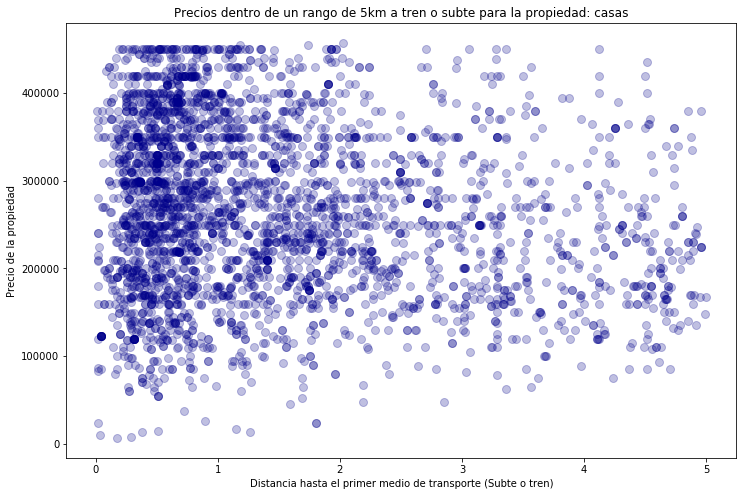

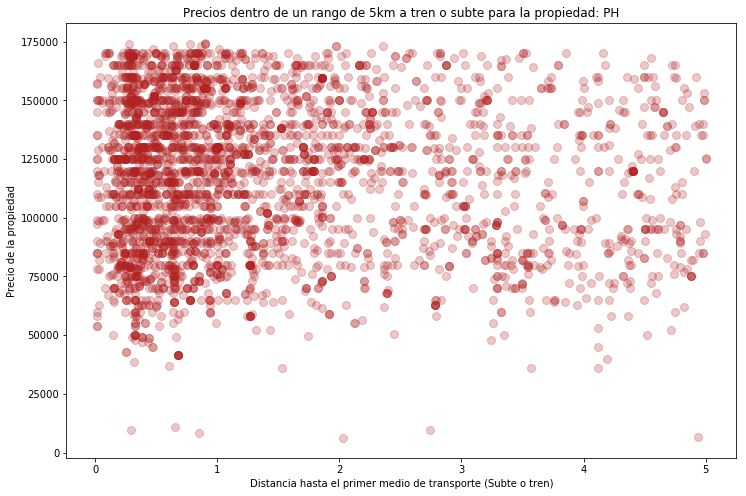

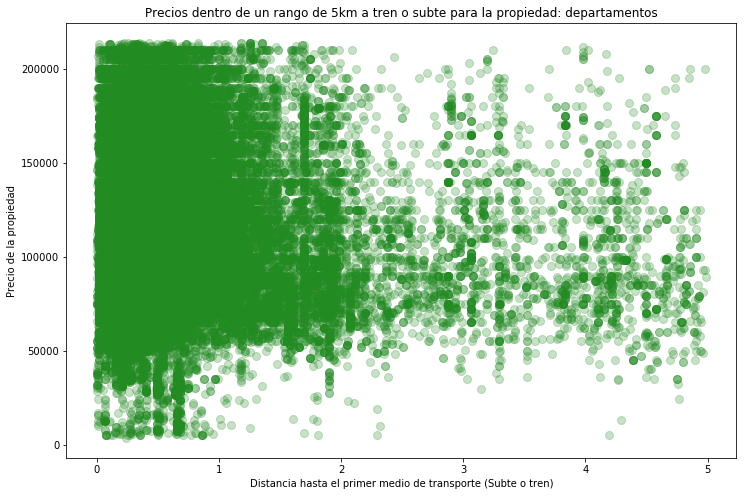

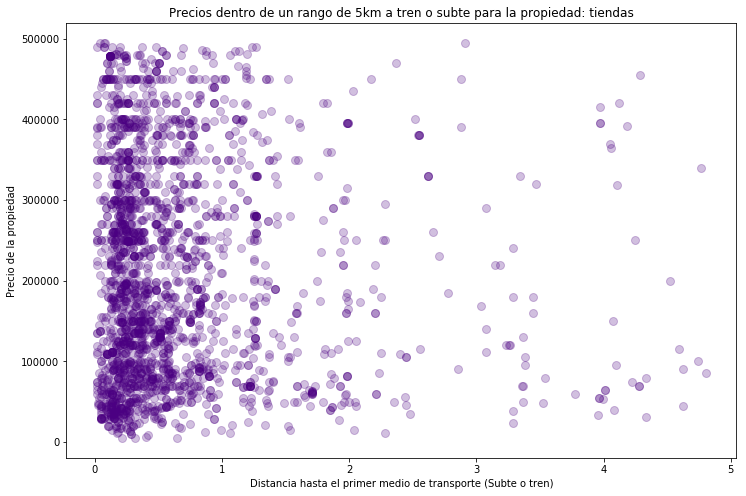

In [32]:
tiposPropiedades = {"apartment":("forestgreen","departamentos"),"house":("darkblue","casas"),\
            "store":("indigo","tiendas"),"PH":("firebrick","PH")}

for prop in tiposPropiedades:
    fig, ax = plt.subplots(figsize=(12,8))
    props = propsCapUltimosAnhos[propsCapUltimosAnhos["property_type"] == prop]
    props = props[props["price_aprox_usd"] < props["price_aprox_usd"].mean() + 500.000]
    ax.plot(props.distMinTransporte, props.price_aprox_usd,marker="o", \
            linestyle='', ms=8,color=tiposPropiedades[prop][0], label=prop, alpha= 0.25)
    plt.title("Precios dentro de un rango de 5km a tren o subte para la propiedad: "+tiposPropiedades[prop][1])
    plt.xlabel("Distancia hasta el primer medio de transporte (Subte o tren)")
    plt.ylabel("Precio de la propiedad")
    plt.show()

### Conclusiones:
#### 1) Se puede ver que mientras mas lejos se esta de los principales medios de transporte, habrán menos publicaciones de ventas de propiedades. Esto se manifiesta mas que nada para las ventas del tipo tiendas, lo cual tiene mucho sentido ya que las zonas mas cercanas a estos dos medios de transporte suelen tener mucho movimiento y por ende zonas de comercio.
#### 2) A medida que me alejo, la cantidad de propiedades con precios altos comienza a decrecer. En los departamentos esto se nota con más claridad

# ¿El precio promedio de una propiedad vale más si está en una esquina? 

In [33]:
#Analizo esto en una muestra de las propiedades con un precio no muy distante del promedio

In [34]:
df["description"] = df["description"].str.lower()
df["extra"] = df["extra"].str.lower()
df["title"] = df["title"].str.lower()

In [35]:
df["Zona"] = df.apply(lambda row: row["place_with_parent_names"].split("|")[2],axis=1)

In [36]:
props_con_precio_cercano_promedio = df[(df["price_aprox_usd"] < (df["price_aprox_usd"].mean() + 130000)) &\
                                      (df["price_aprox_usd"] > (df["price_aprox_usd"].mean() - 130000))]

In [37]:
titlEsquina = props_con_precio_cercano_promedio["title"].str.contains("esquina").fillna(False)
extraEsquina = props_con_precio_cercano_promedio["extra"].str.contains("esquina").fillna(False)
descEsquina = props_con_precio_cercano_promedio["description"].str.contains("esquina").fillna(False)

In [38]:
propsEsquina = props_con_precio_cercano_promedio[titlEsquina | extraEsquina | descEsquina]

In [39]:
propsRestantes = props_con_precio_cercano_promedio[~titlEsquina & ~extraEsquina & ~descEsquina]

In [40]:
data_esquinas_zona = []
zonas = ["Capital Federal", "Bs.As. G.B.A. Zona Norte", "Bs.As. G.B.A. Zona Sur", "Bs.As. G.B.A. Zona Oeste"]
for zona in zonas: #Las 4 zonas que estudiamos
    info_zona = {}
    promedio_esquinas = propsEsquina[propsEsquina["Zona"] == zona]["price_aprox_usd"].mean()
    promedio_entre_esquinas = propsRestantes[propsRestantes["Zona"] == zona]["price_aprox_usd"].mean()
    info_zona["Zona"] = zona
    info_zona["Precio promedio esquinas"] = promedio_esquinas
    info_zona["Precio promedio entre esquinas"] = promedio_entre_esquinas
    data_esquinas_zona.append(info_zona)

In [41]:
esquinas = pd.DataFrame(data_esquinas_zona)
esquinas["Zona"] = esquinas["Zona"].str.replace("Capital Federal","CABA")
esquinas["Zona"] = esquinas["Zona"].str.replace("Bs.As. G.B.A. Zona Norte","Zona Norte")
esquinas["Zona"] = esquinas["Zona"].str.replace("Bs.As. G.B.A. Zona Sur","Zona Sur")
esquinas["Zona"] = esquinas["Zona"].str.replace("Bs.As. G.B.A. Zona Oeste","Zona Oeste")
esquinas.index = esquinas.Zona

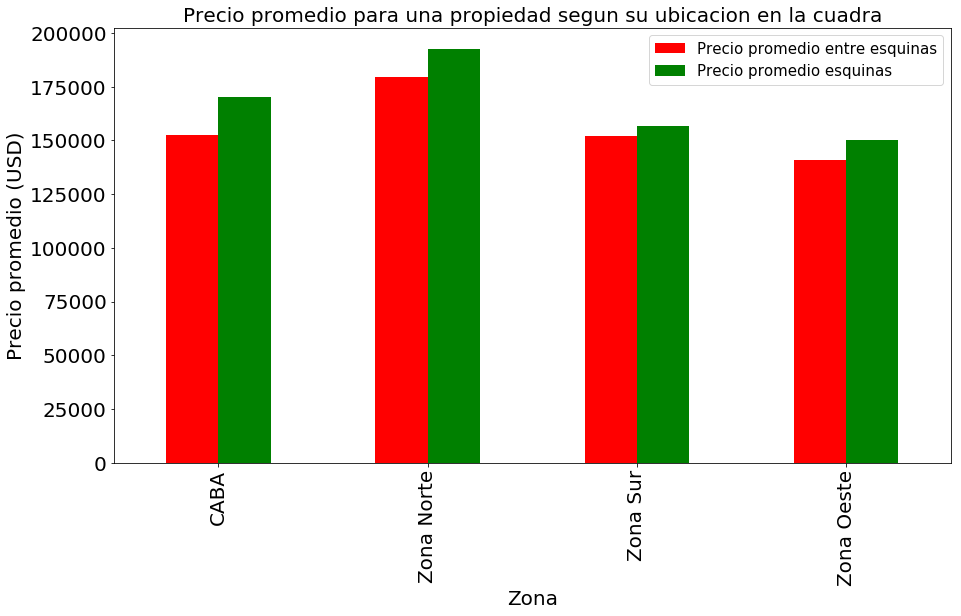

In [42]:
ax = esquinas.plot(kind = "bar", color =["r","g"] ,fontsize=20,figsize = (15,8))
ax.set_xlabel("Zona", fontsize=20)
ax.set_ylabel("Precio promedio (USD)", fontsize=20)
ax.set_title('Precio promedio para una propiedad segun su ubicacion en la cuadra', fontsize = 20)
ax.legend(fontsize = 15)

### Conclusiones:
#### Se ve que dentro de las propiedades que estan en el rango de precio promedio, las que se encuentran ubicadas en una esquina tienen un precio promedio mayor a las que se encuentran entre esquinas. Esto debe ser por las distintas ventajas que tiene una propiedad ubicada en una esquina (Acceso por dos calles distintas, vista, etc..)


In [43]:
df.corr()

floor  geonames_id  price_aprox_usd  \
floor                  1.000000    -0.008670         0.057715   
geonames_id           -0.008670     1.000000        -0.021502   
price_aprox_usd        0.057715    -0.021502         1.000000   
price_usd_per_m2       0.012483    -0.001079         0.029919   
rooms                 -0.023416    -0.018479         0.353051   
surface_covered_in_m2  0.022965    -0.002149         0.073274   
surface_total_in_m2   -0.003281    -0.009560         0.211651   

                       price_usd_per_m2     rooms  surface_covered_in_m2  \
floor                          0.012483 -0.023416               0.022965   
geonames_id                   -0.001079 -0.018479              -0.002149   
price_aprox_usd                0.029919  0.353051               0.073274   
price_usd_per_m2               1.000000 -0.003191              -0.002356   
rooms                         -0.003191  1.000000               0.016225   
surface_covered_in_m2         -0.002356  0.016225               1.000000   
surface_total_in_m2           -0.007404  0.098589               0.257471   

                       surface_total_in_m2  
floor                            -0.003281  
geonames_id                      -0.009560  
price_aprox_usd                   0.211651  
price_usd_per_m2                 -0.007404  
rooms                             0.098589  
surface_covered_in_m2             0.257471  
surface_total_in_m2               1.000000

### Segun las interpretaciones del coeficientes de correlacion definidas en http://www.dmstat1.com/res/TheCorrelationCoefficientDefined.html
#### De esta tabla de correlaciones se podria decir que el precio aproximado de una propiedad esta moderadamente relacionado con la cantidad de ambientes que posee (Su coeficiente de correlacion es 0.34). Esto quiere decir que, a medida que aumenta la cantidad de habitaciones de una propiedad, se veria, aunque de una forma difusa, como aumenta el precio de la propiedad
#### El segundo valor más alto es la correlacion entre la superficie total en m2 y el precio aproximado en usd. En este caso el factor de correlacion es 0.21, es aun mas difuso que el resultado mencionado anteriormente, pero es positivo. 

In [46]:
props_sup_precio_similar = props_con_precio_cercano_promedio\
                        [(props_con_precio_cercano_promedio["surface_total_in_m2"] <\
                        props_con_precio_cercano_promedio["surface_total_in_m2"].mean() + 30) &\
                        (props_con_precio_cercano_promedio["surface_total_in_m2"] >\
                        props_con_precio_cercano_promedio["surface_total_in_m2"].mean() - 30)] 

In [47]:
titleAEstrenar = props_sup_precio_similar["title"].str.contains("a estrenar").fillna(False)
descAEstrenar = props_sup_precio_similar["description"].str.contains("a estrenar").fillna(False)
extraAEstrenar = props_sup_precio_similar["extra"].str.contains("a estrenar").fillna(False)


In [48]:
propsAEstrenar = props_sup_precio_similar[titleAEstrenar | descAEstrenar | extraAEstrenar]                                                

In [49]:
propsViejas = props_sup_precio_similar[~titleAEstrenar & ~extraAEstrenar & ~descAEstrenar]

In [50]:
#propsAEstrenar = _propsAEstrenar[_propsAEstrenar["property_type"] == "store"]
#propsViejas = _propsViejas[_propsViejas["property_type"] == "store"]

In [51]:
data_antiguedad_props = []
zonas = ["Capital Federal", "Bs.As. G.B.A. Zona Norte", "Bs.As. G.B.A. Zona Sur", "Bs.As. G.B.A. Zona Oeste"]
tipos = ["apartment", "house", "store", "PH"]
for zona in zonas: #Las 4 zonas que estudiamos
    info_zona = {}
    for tipo_prop in tipos:
        
        promedio_viejas = propsViejas[(propsViejas["Zona"] == zona) &\
                                      (propsViejas["property_type"] == tipo_prop)]["price_aprox_usd"].mean()
        promedio_nuevas = propsAEstrenar[(propsAEstrenar["Zona"] == zona) &\
                                         (propsAEstrenar["property_type"] == tipo_prop)]["price_aprox_usd"].mean()
        info_zona["Zona"] = zona
        info_zona[tipo_prop+" a estrenar"] = promedio_nuevas
        info_zona[tipo_prop+" vieja"] = promedio_viejas
    data_antiguedad_props.append(info_zona)

In [52]:
antiguedadPropsdf = pd.DataFrame(data_antiguedad_props)

In [53]:

antiguedadPropsdf["Zona"] = antiguedadPropsdf["Zona"].str.replace("Capital Federal","CABA")
antiguedadPropsdf["Zona"] = antiguedadPropsdf["Zona"].str.replace("Bs.As. G.B.A. Zona Norte","Zona Norte")
antiguedadPropsdf["Zona"] = antiguedadPropsdf["Zona"].str.replace("Bs.As. G.B.A. Zona Sur","Zona Sur")
antiguedadPropsdf["Zona"] = antiguedadPropsdf["Zona"].str.replace("Bs.As. G.B.A. Zona Oeste","Zona Oeste")
antiguedadPropsdf.index = antiguedadPropsdf.Zona

In [54]:
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
#legend([plot1], "title", prop = fontP)

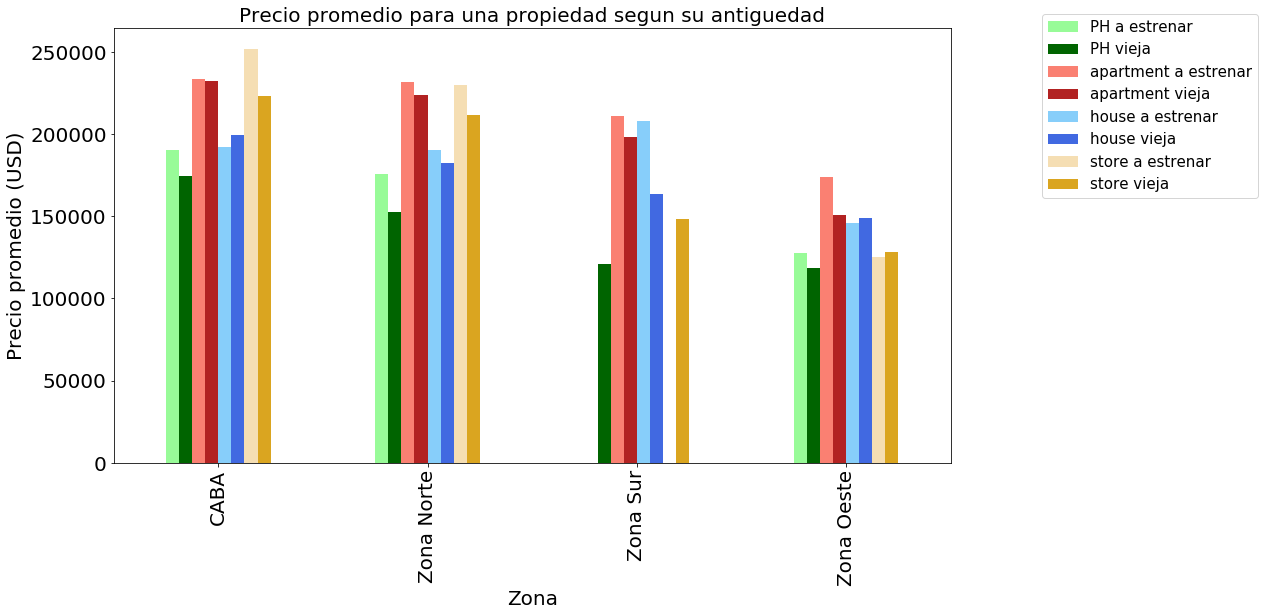

In [55]:


ax = antiguedadPropsdf.plot(kind = "bar",\
                            color =["palegreen","darkgreen","salmon","firebrick","lightskyblue","royalblue","wheat","goldenrod"] ,\
                            fontsize=20,figsize = (15,8))
ax.set_xlabel("Zona", fontsize=20)
ax.set_ylabel("Precio promedio (USD)", fontsize=20)
ax.set_title('Precio promedio para una propiedad segun su antiguedad', fontsize = 20)
ax.legend(bbox_to_anchor=(1.1, 1.05), fontsize = 15)



### Conclusiones:
#### En general se ve que el precio promedio de una propiedad a estrenar es mayor a una propiedad vieja. Salvo el caso de las casas en CABA y las casas y tiendas en Zona Oeste. Tambien se ve que en Zona Sur no hay ni PH's a estrenar ni tiendas a estrenar. 

# Historicamente, donde se encontraban las propiedades más caras y las más baratas?

In [51]:
import folium

In [57]:
map_osm = folium.Map(location=[-34.556272, -58.465813])

In [58]:
orden_mas_caras = props_sup_precio_similar.sort_values("price_aprox_usd", axis = 0, ascending = False)
orden_mas_caras.dropna(subset=["lat-lon"],inplace=True)

In [59]:
top_500_mas_caras = orden_mas_caras.head(500)
top_500_mas_baratas = orden_mas_caras.tail(500)

In [63]:
for index, row in top_500_mas_caras.iterrows():
    precio = str(int(row["price_aprox_usd"]))+" USD"
    loc = (latLonToInt(row["lat-lon"])[0],latLonToInt(row["lat-lon"])[1])
    folium.CircleMarker(location= loc,color = 'green', popup = precio).add_to(map_osm)    
     
for index, row in top_500_mas_baratas.iterrows():
    precio = str(int(row["price_aprox_usd"]))+" USD"
    loc = (latLonToInt(row["lat-lon"])[0],latLonToInt(row["lat-lon"])[1])
    folium.CircleMarker(location= loc,color = 'red', popup = precio).add_to(map_osm)    
    
map_osm

### Conclusiones: 
#### Los resultados de esta visualizacion eran esperados. El grueso de las propiedades más caras se concentra en la zona norte de CABA. Vemos que hay algunas en tambien en el este de la zona norte. Por otro lado, tambien era de esperarse que las propiedades más baratas se encuentren en zona sur y oeste. Tambien se ven algunos datos anomalos como una propiedad en Uruguay

# Para los distritos que limitan con el río, que se puede observar de los precios de las mismas en relacion a la cercania al rio? 

In [ ]:
#Armo un dataFrame con las 100 propiedades mas caras y mas baratas de cada localidad que da contra el rio

In [77]:
limitan_rio = ["Tigre", "Rincón de Milberg", "San Fernando",  "Victoria", "Beccar",
               "San Isidro", "Acassuso", "La Lucila", "Martínez",  "Olivos",
                "Vicente López", "Belgrano", "Palermo", "Recoleta", "retiro", "Puerto Madero", "Boca", "Monserrat", "Barracas",
                "Avellaneda", "Quilmes", "Florencio Varela"]
df_partitions_mas_caras = []
df_partitions_mas_baratas = []
for localidad in limitan_rio:
    data_localidad = df[df["place_name"] == localidad]
    props_mas_caras = data_localidad.sort_values("price_aprox_usd", axis = 0, ascending = False).head(100)
    props_mas_baratas = data_localidad.sort_values("price_aprox_usd", axis = 0, ascending = False).tail(100)
    df_partitions_mas_caras.append(props_mas_caras)
    df_partitions_mas_baratas.append(props_mas_baratas)


In [78]:
df_rio_caras = pd.concat(df_partitions_mas_caras)
df_rio_baratas = pd.concat(df_partitions_mas_baratas)

In [79]:
map_rio = folium.Map(location=[-34.556272, -58.465813])
for index, row in df_rio_caras.iterrows():
    loc = (latLonToInt(row["lat-lon"])[0],latLonToInt(row["lat-lon"])[1])
    folium.CircleMarker(location= loc,color = 'green').add_to(map_rio)    
for index, row in df_rio_baratas.iterrows():
    loc = (latLonToInt(row["lat-lon"])[0],latLonToInt(row["lat-lon"])[1])
    folium.CircleMarker(location= loc,color = 'red').add_to(map_rio)    

map_rio

### Conclusiones:
#### Para la Zona Norte desde San Fernando hasta Martínez se puede ver que las propiedades más caras se acumulan en cercanias de la costa, un poco más alejadas de las propiedades más baratas
#### Para las propiedades de los barrios de capital, salvo en contados sectores, no parece haber una tendencia a que las propiedades mas baratas esten mas alejadas de la costa, si no que se ven tambien agrupadas a las propiedades más caras